# Loading data from HDR+ dataset

The HDR+ dataset is a collection of raw and processed images captured with Google's HDR+ computational photography pipeline. 

It typically includes raw sensor data (DNG files), metadata, and the final high dynamic range (HDR) output images, often used for research in image processing, computational photography, and low-light imaging.

More info is on dataset's page: https://hdrplusdata.org/dataset.html

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import PIL
import rawpy
import tifffile

from dataset.hdrplus_downloader import HDRPlusDatasetDownloader
from utils import plot_images

%matplotlib inline
# Set the default figure format for inline matplotlib plots to JPEG for smaller file sizes and faster rendering
%config InlineBackend.figure_format = 'jpeg'
# Configure matplotlib to save figures with tight bounding boxes (removes extra whitespace)
%config InlineBackend.rc = {'savefig.bbox': 'tight'}


Utilizing a custom HDR+ dataset downloader, we can download an arbitrary folder containing raw files and the final image (generated by the HDR+ pipeline). This image will serve as our reference.

In [2]:
downloader = HDRPlusDatasetDownloader()
source_path = Path("hdrplusdata/20171106_subset/bursts/0006_20160722_115157_431")
folder_path = downloader.download(source_path)

source_result_folder = "hdrplusdata/20171106/results_20161014/0006_20160722_115157_431/final.jpg"
result_image_path = downloader.download(source_result_folder, folder_path / "results")

2026-01-22 16:29:47.577 | INFO     | dataset.hdrplus_downloader:download:55 - Destination path wasn't explicitly set. Downloading into `/Users/andreiaksionau/Developer/Computational_Photography/ISPFoundry/data/raw/hdrplus_dataset`
2026-01-22 16:29:47.578 | INFO     | dataset.hdrplus_downloader:download:61 - Folder already exists. Force download was disabled.
2026-01-22 16:29:47.578 | INFO     | dataset.hdrplus_downloader:download:61 - Folder already exists. Force download was disabled.


In [3]:
folder_content = sorted(folder_path.iterdir())
filenames = [p.name for p in folder_content if p.is_file()]
print(f"Number of files: {len(filenames)}")
display(filenames)

Number of files: 16


['lens_shading_map_N000.tiff',
 'lens_shading_map_N001.tiff',
 'lens_shading_map_N002.tiff',
 'lens_shading_map_N003.tiff',
 'lens_shading_map_N004.tiff',
 'lens_shading_map_N005.tiff',
 'lens_shading_map_N006.tiff',
 'payload_N000.dng',
 'payload_N001.dng',
 'payload_N002.dng',
 'payload_N003.dng',
 'payload_N004.dng',
 'payload_N005.dng',
 'payload_N006.dng',
 'rgb2rgb.txt',
 'timing.txt']

The folder contains 16 files:

- **7 Lens Shading Correction Maps**: 4-channel floating-point TIFF images used to compensate for vignetting and color shading across the sensor.
- **7 Raw Image Files**: DNG files containing the original sensor data captured in a Bayer mosaic pattern.
- **rgb2rgb.txt**: A text file containing the coefficients for a 3x3 color correction matrix (CCM) to transform from sensor RGB to linear sRGB.
- **timing.txt**: A log file providing performance metrics for the three main stages (Align, Merge, and Finish) of the original HDR+ pipeline.

## 1. Inspecting the reference image

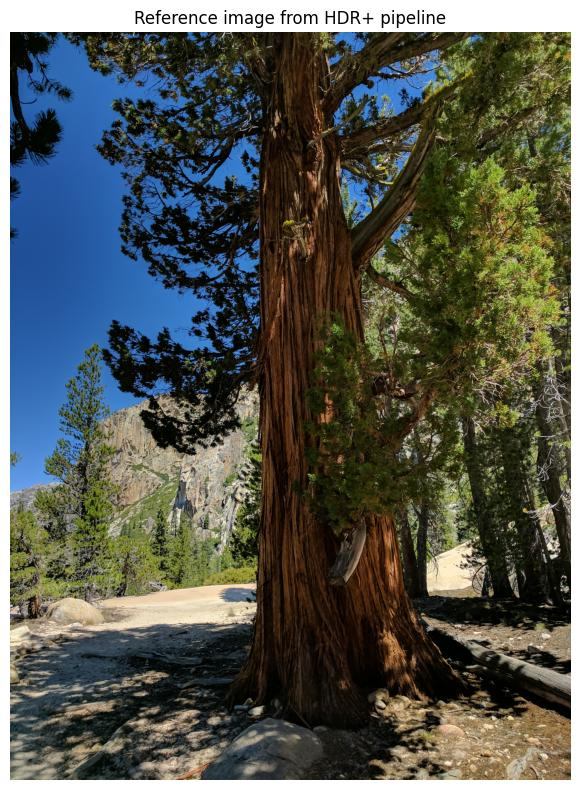

In [4]:
plot_images(np.array(PIL.Image.open(result_image_path)), "Reference image from HDR+ pipeline")

This image captures a high-contrast scene with a tree in deep shadows against a bright sky. Such a scene typically exceeds the dynamic range of a single sensor exposure, resulting in either clipped highlights or lost shadow detail. It is an ideal candidate for high dynamic range (HDR) processing, which aims to preserve and display detail across the entire tonal range from the darkest shadows to the brightest highlights.

## 2. Inspecting files with raw image data

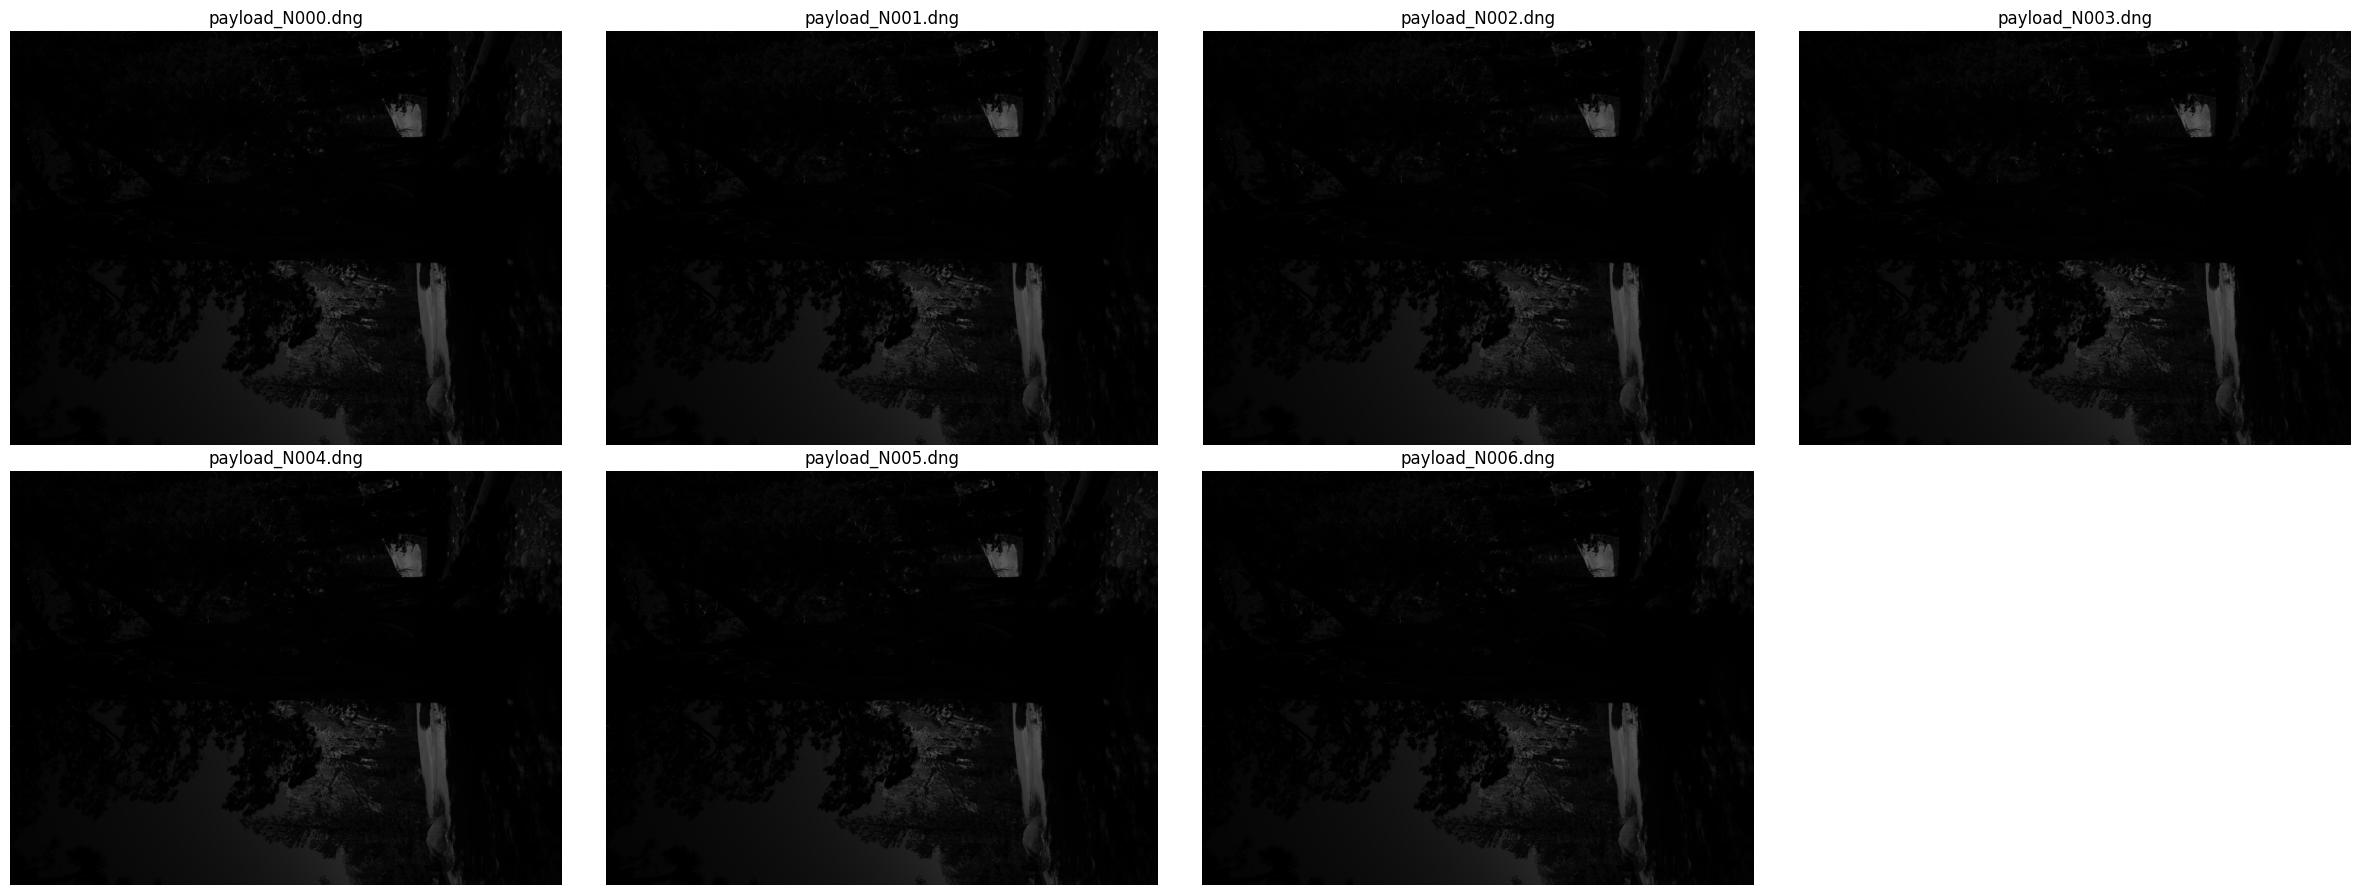

In [5]:
plot_data = {"images": [], "titles": []}
ref_cfa = set()
cfa_indices = set()

for dng_path in (p for p in folder_content if p.match("payload_*.dng")):
    with rawpy.imread(str(dng_path)) as raw_obj:
        plot_data["images"].append(raw_obj.raw_image)
        plot_data["titles"].append(dng_path.name)
        ref_cfa.add(raw_obj.color_desc)
        cfa_indices.add(tuple(raw_obj.raw_pattern.flatten().tolist()))

plot_images(**plot_data, max_per_row=4)
del plot_data

The dataset provides a burst of 7 raw images of the same scene.

#### Burst Processing & SNR
Capturing a burst allows for temporal noise reduction. By aligning and averaging these frames, we increase the Signal-to-Noise Ratio (SNR). This process lowers the noise floor in the shadows, effectively increasing the usable dynamic range by widening the gap between the noise floor and the saturation level.

#### Exposure Strategy
The images appear dark because they are captured with short exposure times. This is a deliberate strategy to:
1. **Prevent Highlight Clipping:** Shorter exposures preserve detail in bright areas (e.g., the sky).
2. **Minimize Blur:** Reducing exposure time limits motion blur and camera shake.
3. **Facilitate Merging:** Less time between frames results in smaller displacements, making the alignment and merging process more robust.

#### Color Filter Array (CFA) & Demosaicing
Raw images are single-channel mosaics. Each pixel captures intensity through a specific filter (Red, Green, or Blue) arranged in a Color Filter Array (CFA) - most commonly the Bayer pattern. Because each pixel only records one color, we must eventually perform **demosaicing** (interpolation) to reconstruct a full RGB image.

Let's identify the specific CFA pattern used by this sensor.

In [6]:
assert len(ref_cfa) == 1
assert len(cfa_indices) == 1
ref_cfa = ref_cfa.pop()
cfa_indices = cfa_indices.pop()

print(f"Reference CFA pattern is {ref_cfa} and channel indices are `{cfa_indices}`")

Reference CFA pattern is b'RGBG' and channel indices are `(2, 3, 1, 0)`


In [7]:
cfa_pattern = "".join(np.array(list(ref_cfa.decode()))[[*cfa_indices]])
print(f"CFA pattern of raw images is `{cfa_pattern}`")


CFA pattern of raw images is `BGGR`


All raw images in the burst share a consistent CFA pattern: **BGGR**. This specifies the arrangement of color filters over the pixel sensor array in a repeating 2x2 block:

    +---+---+---+---+
    | B | G | B | G |
    +---+---+---+---+
    | G | R | G | R |
    +---+---+---+---+
    | B | G | B | G |
    +---+---+---+---+
    | G | R | G | R |
    +---+---+---+---+

This differs from the more common **RGGB** layout:


    +---+---+---+---+
    | R | G | R | G |
    +---+---+---+---+
    | G | B | G | B |
    +---+---+---+---+
    | R | G | R | G |
    +---+---+---+---+
    | G | B | G | B |
    +---+---+---+---+


Identifying the correct CFA layout is a critical first step for the ISP pipeline. It determines how we index the raw data for black level subtraction, how we apply channel-specific gains during white balancing, and how the demosaicing algorithm interpolates the missing color components for each pixel.

As said on dataset's page:

> For devices that include optically shielded pixels, the images have been cropped to the active pixel array. For the minority of shots captured with digital zoom, the raw input has been pre-cropped to the photographer-selected field of view.

That might explain `BGGR` pattern: if you crop one pixel from each side, you will get exactly `BGGR`.


## 3. Inspecting Lens Shading Maps

According to the [dataset page](https://hdrplusdata.org/dataset.html), lens shading map is:

> Low-resolution floating-point gain maps listing the coefficients used to correct the input for both color shading and vignetting, for each Bayer color channel. Stored as 4-channel floating-point TIFF images. The channel order is [R, Gred, Gblue, B], where Gred is the green channel for the red-containing rows of a Bayer pattern, and Gblue is for the blue-containing rows.

Lens shading maps shapes: {(13, 17, 4)}


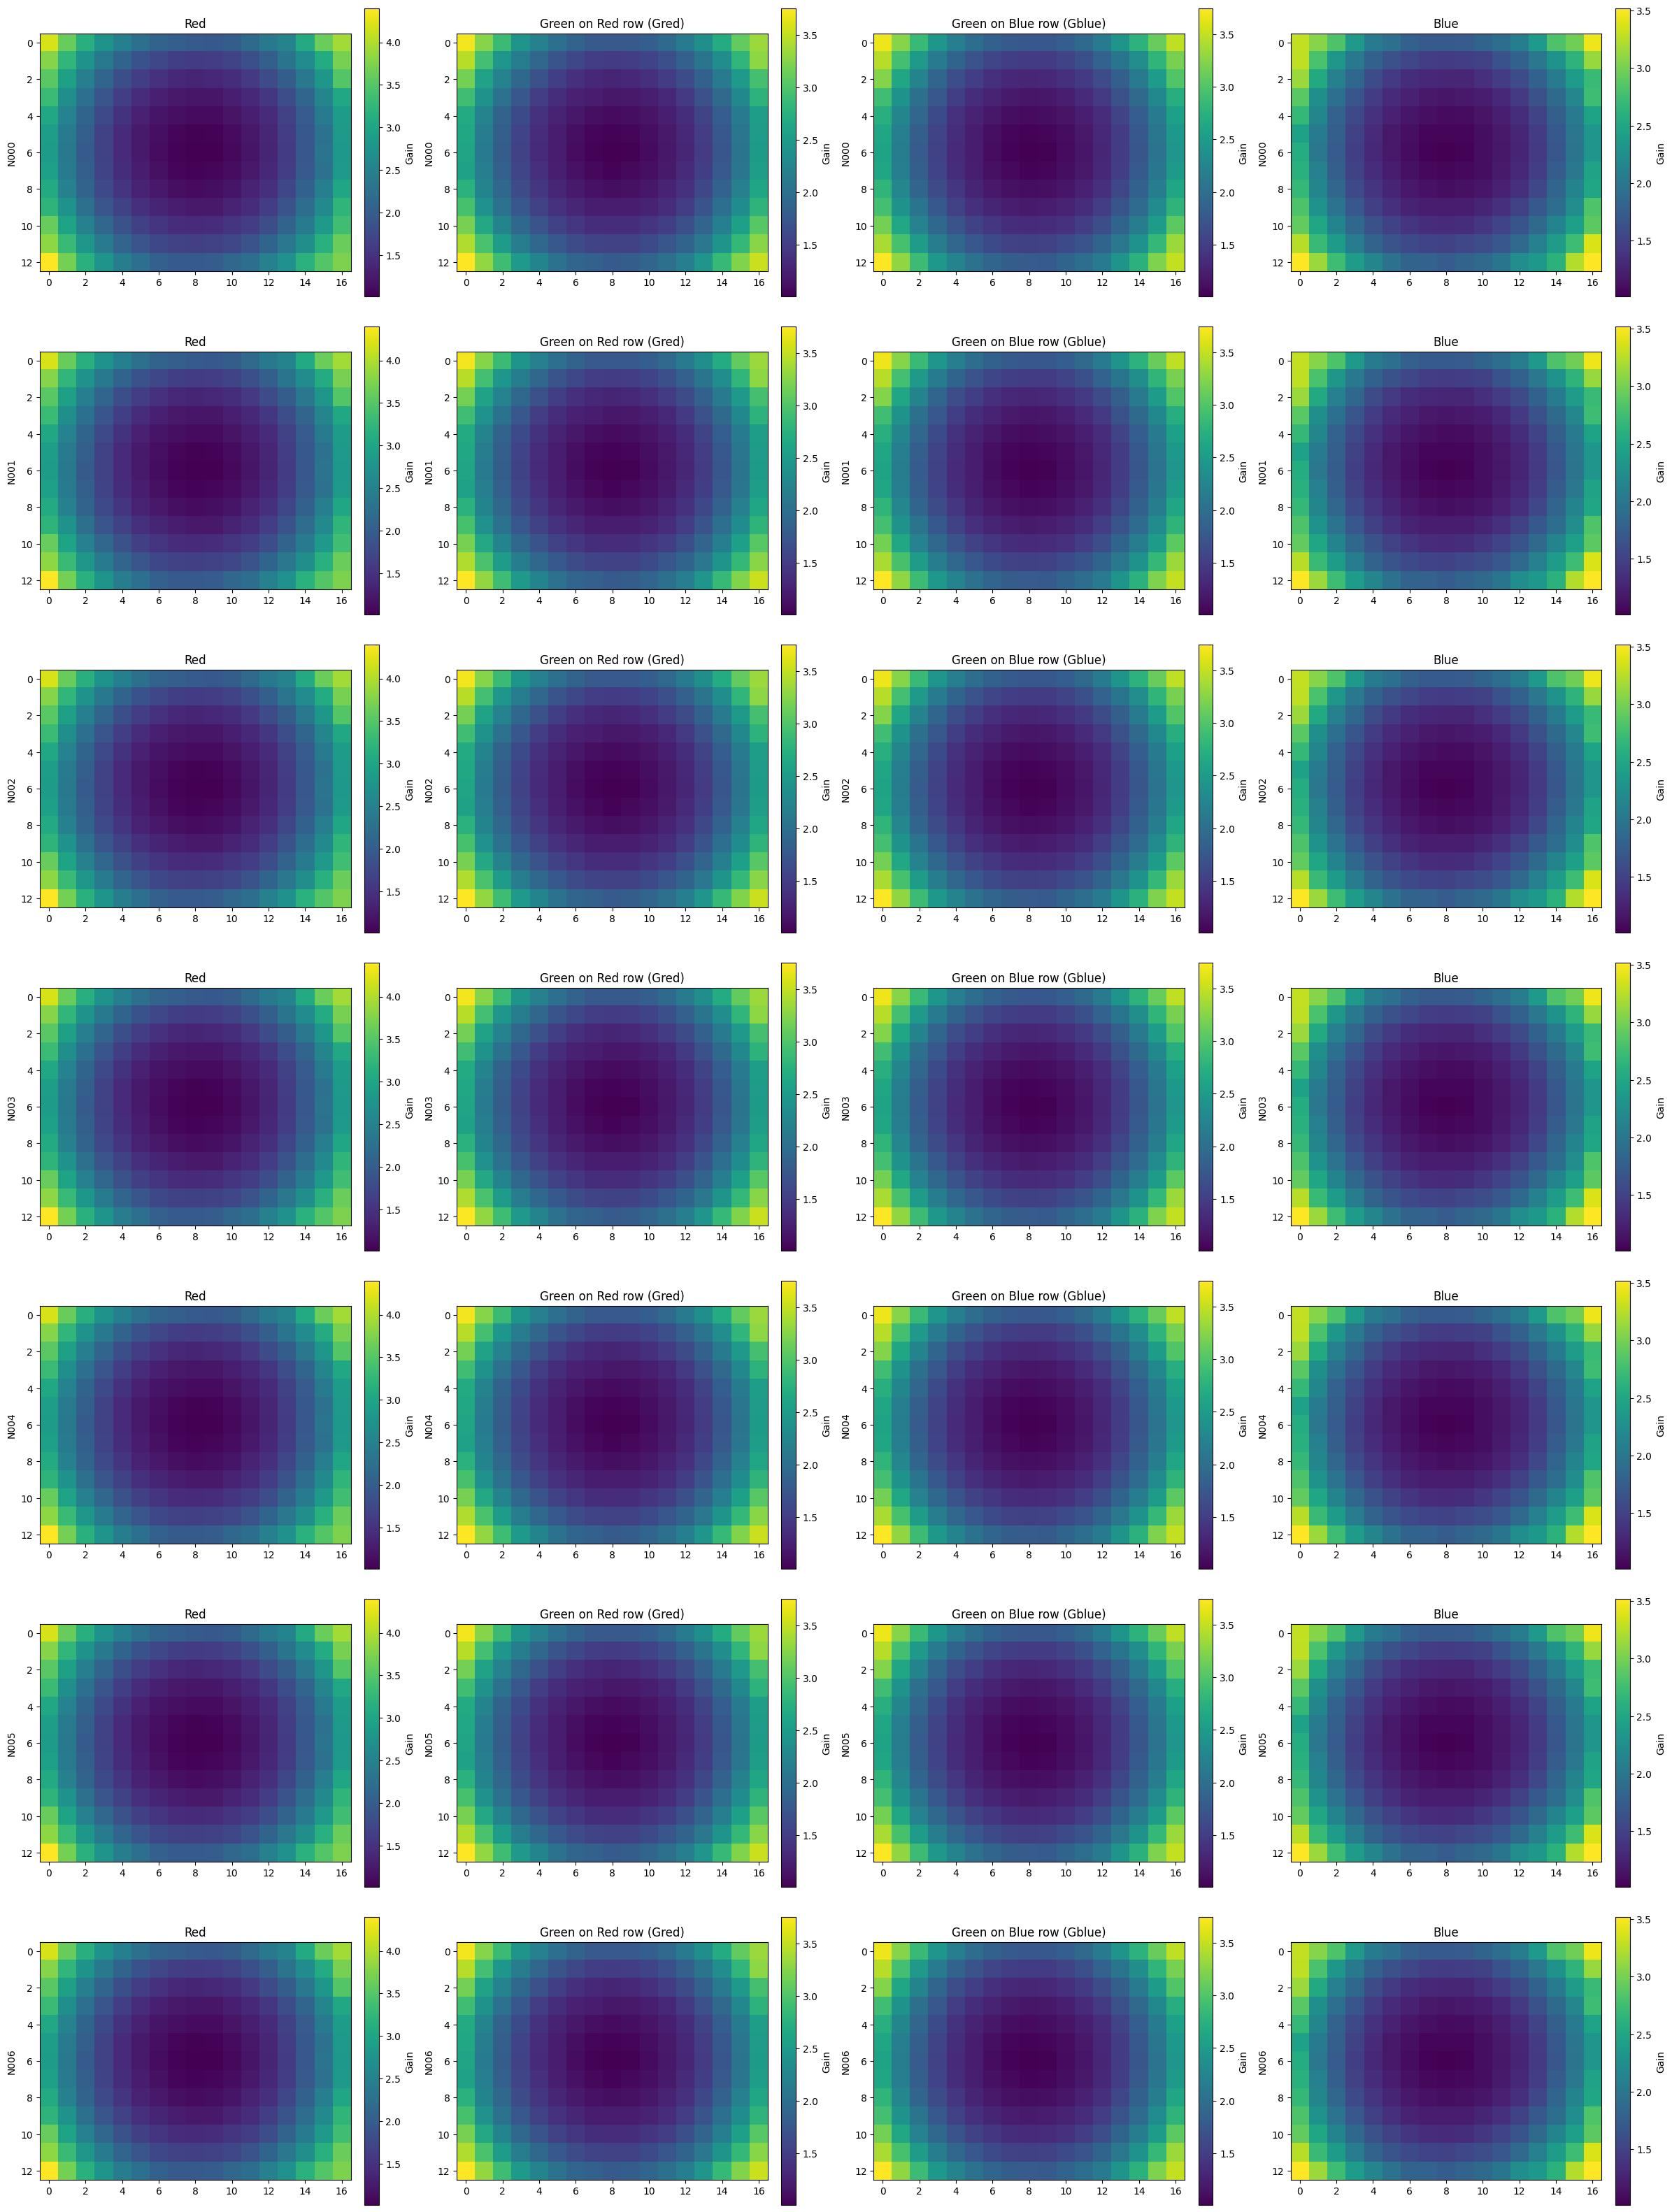

In [8]:
channel_names = ["Red", "Green on Red row (Gred)", "Green on Blue row (Gblue)", "Blue"]
lns_paths = [p for p in folder_content if p.match("lens_shading_map_*.tiff")]
lns_shapes = set()

fig, axes = plt.subplots(len(lns_paths), 4, figsize=(24, 32))
axes = axes.flat


for lns_path in lns_paths:
    lns = tifffile.imread(lns_path)
    lns_shapes.add(lns.shape)

    for ch_idx in range(4):
        ax = next(axes)
        ax.set_title(f"{channel_names[ch_idx]}")
        ax.set_ylabel(lns_path.stem.split("_")[-1])
        im = ax.imshow(lns[..., ch_idx], cmap="viridis")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Gain")

plt.tight_layout()

print(f"Lens shading maps shapes: {lns_shapes}")

Each file contains a low-resolution grid of floating-point gains. At the optical center, the gain is typically 1.0 (no correction), and it increases toward the edges to compensate for **vignetting** - the reduction in light intensity at the periphery caused by the lens geometry and sensor characteristics.

A coarse map *(13x17)* is sufficient because lens shading is a **low-frequency phenomenon**; it varies very smoothly across the sensor. During the ISP pipeline, the full-resolution gain for every pixel is calculated by performing bilinear interpolation on this coarse grid, which saves significant memory and storage while maintaining correction accuracy.

## 4. Inspecting rgb2rgb.txt

According to the [dataset page](https://hdrplusdata.org/dataset.html), rgb2rgb.txt file contains:

> Coefficients of the 3x3 color transform matrix to use to transform from sensor RGB color space to output linear sRGB color space, serialized in row-major order. 

In [9]:
rgb2rgb = (folder_path / "rgb2rgb.txt").read_text()
print(rgb2rgb)

rgb2rgb = np.fromstring(rgb2rgb, sep=" ").reshape((3, 3))
print(rgb2rgb)

1.6640625 -0.6796875 0.0078125 -0.1484375 1.3046875 -0.1484375 0.109375 -0.7421875 1.640625

[[ 1.6640625 -0.6796875  0.0078125]
 [-0.1484375  1.3046875 -0.1484375]
 [ 0.109375  -0.7421875  1.640625 ]]


In other words, this 3x3 **Color Correction Matrix (CCM)** maps the device-dependent sensor RGB space to a standard, device-independent color space (specifically linear sRGB in this dataset). Because every sensor has a unique spectral sensitivity defined by its hardware, this matrix is essential for achieving accurate color reproduction. Once the data is in a standard color space, it can be easily transformed to any desired output gamut or encoding, such as standard sRGB for display.

In this pipeline, we will derive this matrix from scratch by using image metadata from EXIF.

<div class="alert alert-block alert-info"><b>Important</b>:
It is not possible to derive a matrix from EXIF metadata that perfectly matches the provided `rgb2rgb.txt` file. The HDR+ pipeline uses a matrix specifically tuned by solving an optimization equation against a custom dataset of images with reference "desired" colors.

While DNG metadata (like ColorMatrix and ForwardMatrix) provides a standard way to map sensor values to CIE XYZ (and then to sRGB), the rgb2rgb.txt matrix is unique to the HDR+ pipeline. According to the dataset documentation and the original research paper, these coefficients were obtained by solving an optimization problem on a custom dataset of images with specific "desired" reference colors. The standard EXIF matrices are generic sensor calibrations that do not account for the specific aesthetic tuning and optimization used by Google's HDR+ algorithm.
</div>

## 5. Inspecting timing.txt

In [10]:
timing = (folder_path / "timing.txt").read_text()
print(timing)

Align       555.89 ms
Merge      1137.70 ms
Finish     1336.77 ms



The timing log reveals the three primary stages of the HDR+ architecture:

1.  **Align:** The pipeline identifies a reference frame and aligns the other frames in the burst to it. This usually involves a hierarchical (pyramid-based) search to account for both large camera motion and subtle local movements.
2.  **Merge:** Aligned frames are combined using temporal averaging. This step is where the Signal-to-Noise Ratio (SNR) is significantly improved, effectively increasing the bit depth and usable dynamic range of the raw data.
3.  **Finish:** The merged high-fidelity raw image is processed through a standard ISP (Black Level, White Balance, Demosaic, CCM) followed by sophisticated local and global tone mapping to compress the high dynamic range into a format suitable for standard displays.

The original HDR+ pipeline is implemented in **Halide**, a domain-specific language designed to decouple image processing algorithms from their execution schedule. Halide allows for extreme optimization via tiling, vectorization, and multi-threading. Since our implementation relies primarily on Python and NumPy, we should expect significantly longer execution times.